In [12]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def get_cal_score(data, labels):
    return metrics.calinski_harabasz_score(data, labels)

In [2]:
df = pd.read_csv('data.csv')
df.shape


(288, 7)

In [3]:
columns = list(df.columns)
columns

['index',
 'totalCarNumber',
 'numberOfTrips',
 'median_overhead',
 'q1_overhead',
 'q3_overhead',
 'p9_overhead']

In [4]:
df_before =df.iloc[:144, :]


indexes = np.array_split(df_before.index,8, axis=0)
for i,index in enumerate(indexes):
    df_before.loc[index,'group'] = i
    
df_before['c'] = df_before['group'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# print(len(index_list))
# print('\n')
# print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# len(list_of_dfs)

/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [5]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
#                 print(test_data)
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
#         plt.plot(silhouette_range[:], silhouette_scores[:], label = title)
#         plt.xlabel('Number of Clusters')
#         plt.ylabel('Silhouette Score')
#         plt.title(title)
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
#         plt.show()
#         plt.close() 
        max_score = max(silhouette_scores)
#         print(results_dict)
        for i in results_dict:
            if i[1] == max_score:
#                 print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
#                 print(f'{max_score}')
                return int(i[0])
    else:
#         print('couldnt get the scores, plz help')
#         print('returning number of clusters = ' + str(n_clusters_min))
#         model_cpy = copy.deepcopy(model)
#         model_cpy.set_params(n_clusters=2)

#         model_cpy.partial_fit()
#         labels = model_cpy.predict(test_data)
#         s = metrics.silhouette_score(test_data, labels, metric='euclidean')
#         print(f'{s}')

        return n_clusters_min

In [6]:
def combine_dfs(df_list):
    return pd.concat(df_list)

In [7]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    # to_drop = [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,265,266]
    # data_split_modified_z.drop(to_drop, inplace=True)
#     data_split_modified_z = data_split_modified_z.iloc[:144, :]
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#         print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

# a day of data (no accident)

In [13]:
model_005_before= Birch(n_clusters=None, threshold=0.2)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)


In [14]:
fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
#     print(f'fit number: {fit_number}')

    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_005_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1


51.89948072082354
93.4809737241591
170.5128007838145
286.36663286601726
348.73240939448056
410.4984850215157
332.4575428363244
339.6700359479106


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

In [10]:
len(labels_dict)

8

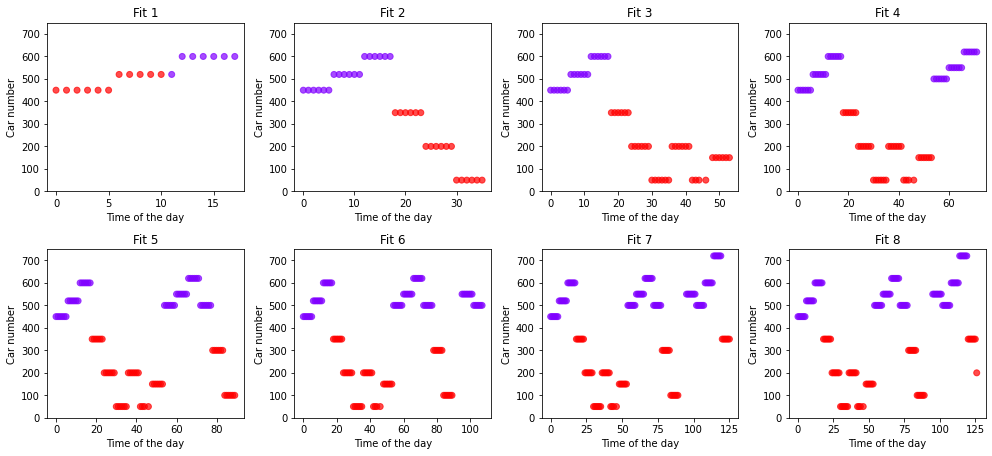

In [17]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,7))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

---
# whole two days of data
## day one - normal traffic 
## day two - accident

In [18]:
indexes = np.array_split(df.index,16, axis=0)
for i,index in enumerate(indexes):
    df.loc[index,'group'] = i
    
df['c'] = df['group'].diff()
df_filtered = df[df['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

len(list_of_dfs)

16


[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270]


16

# THIS IS THE CORRECT SHIT 

In [13]:
##########################################################
###############     THRESHOLD 0.01       #################
##########################################################


model_001_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_001_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.01')
n = plot_silhouette_scores(model_001_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_001_whole.set_params(n_clusters = n)
model_001_whole.partial_fit()

lablels_001 = model_001_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.05      #################
##########################################################


model_005_whole = Birch(n_clusters=None, threshold=0.05)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_005_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.05')
n = plot_silhouette_scores(model_005_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_005_whole.set_params(n_clusters = n)
model_005_whole.partial_fit()

lablels_005 = model_005_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.1       #################
##########################################################


model_01_whole = Birch(n_clusters=None, threshold=0.1)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_01_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.1')
n = plot_silhouette_scores(model_01_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_01_whole.set_params(n_clusters = n)
model_01_whole.partial_fit()

lablels_01 = model_01_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.2       #################
##########################################################


model_02_whole = Birch(n_clusters=None, threshold=0.2)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_02_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.1')
n = plot_silhouette_scores(model_02_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_02_whole.set_params(n_clusters = n)
model_02_whole.partial_fit()

lablels_02 = model_02_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.3      #################
##########################################################



model_03_whole = Birch(n_clusters=None, threshold=0.3)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_03_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.3')
n = plot_silhouette_scores(model_03_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.3')
model_03_whole.set_params(n_clusters = n)
model_03_whole.partial_fit()

lablels_03 = model_03_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.5      #################
##########################################################

model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_05_whole.partial_fit(numpy_array[:, :-2])
    
print('THRESHOLD 0.5')
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
n = plot_silhouette_scores(model_05_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_05_whole.set_params(n_clusters = n)
model_05_whole.partial_fit()

lablels_05 = model_05_whole.predict(new_nmpy[:, :-2])

THRESHOLD 0.01


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0.8753582274223032
THRESHOLD 0.05
0.8753582274223032
THRESHOLD 0.1


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0.8753582274223032
THRESHOLD 0.1
0.8753582274223032
THRESHOLD 0.3
0.7685236997266502
THRESHOLD 0.5
0.8753582274223032


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

new_nmpy = []

for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_05_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
n = plot_silhouette_scores(model_05_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.3')
model_05_whole.set_params(n_clusters = n)
model_05_whole.partial_fit()

lablels_05 = model_05_whole.predict(new_nmpy[:, :-2])

0.8753582274223032


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


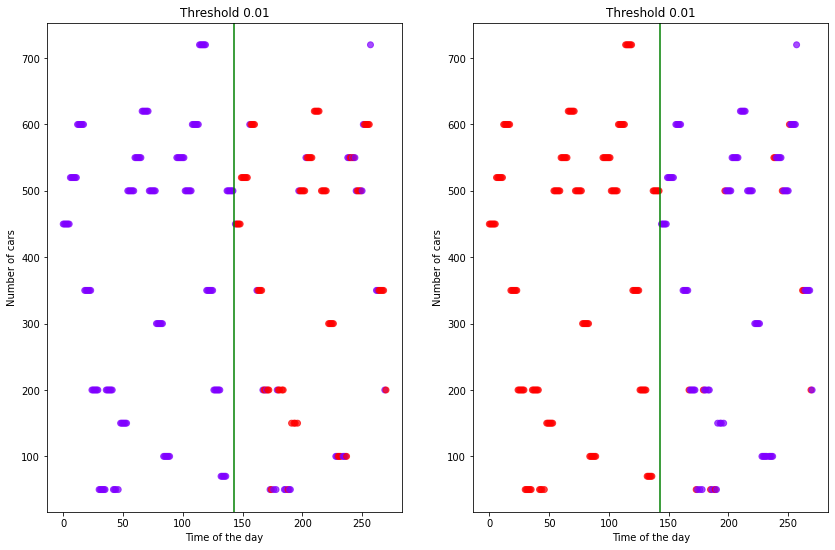

In [15]:
figure, axs = plt.subplots(nrows=1, ncols=2,figsize=(14,9))

axs[0].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_03, cmap='rainbow', alpha=0.7)
axs[0].axvline(x=143, color='g')
axs[0].set_ylabel('Number of cars')
axs[0].set_xlabel('Time of the day')
axs[0].title.set_text("Threshold 0.01")

axs[1].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_05, cmap='rainbow', alpha=0.7)
axs[1].axvline(x=143, color='g')
axs[1].set_ylabel('Number of cars')
axs[1].set_xlabel('Time of the day')
axs[1].title.set_text("Threshold 0.01")

In [22]:
new_nmpy[0]

array([  1.70518154,   1.35979283,   2.12308416,   2.71841847,
       450.        ,   0.        ])

In [19]:
model_005_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

In [20]:
fit_number = 1

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
#     print(f'fit number: {fit_number}')
    numpy_array = outliers_removal(list_of_dfs[i])
    removed_outliers_numpy.append(numpy_array)
    
    model_005_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_005_whole)
    
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, 'threshold 0.05')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))

    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

59.66019123358649
93.4809737241591
188.59064498147887
231.7186153617076
348.73240939448056
410.4984850215157
332.4575428363244
424.30574757681546
4132.988469688765
3144.9474294517895
2325.072012483192
3008.2673856533497
3388.7027510471858
3194.7078447032386
3478.3504550966118


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


3044.640364579189


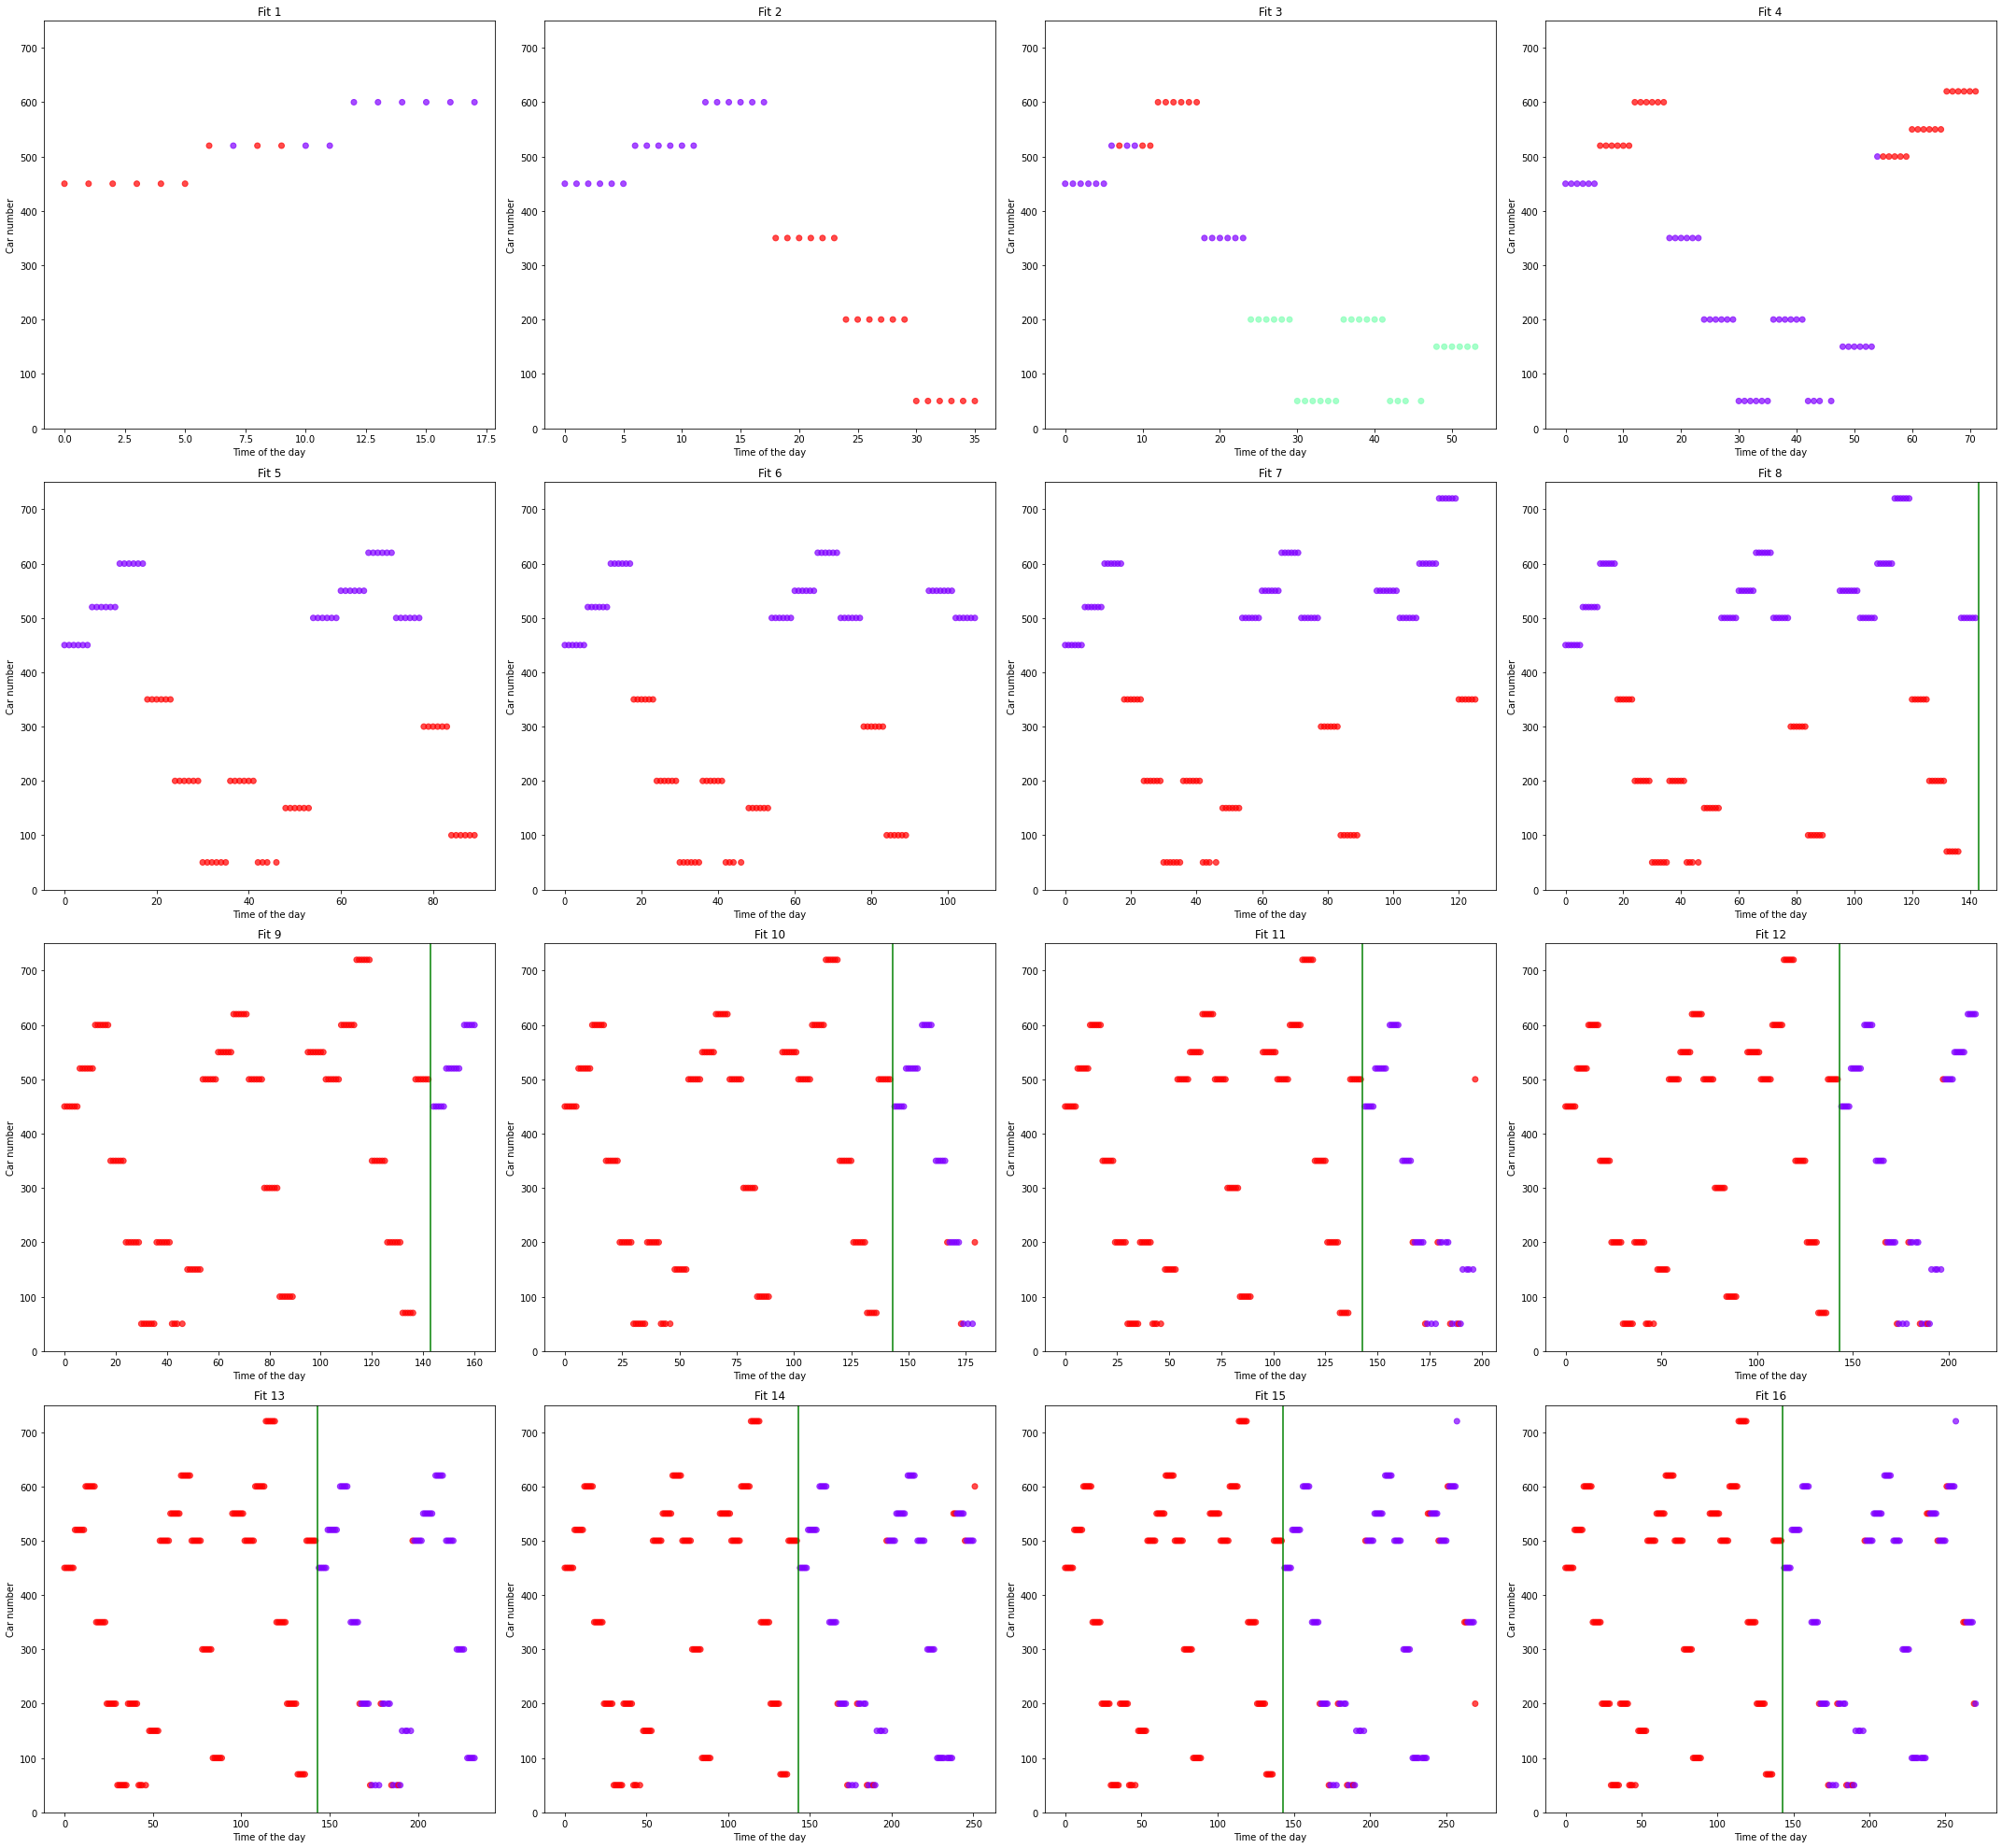

In [21]:
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(30,30))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 8:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [25]:
list_of_dfs[0]

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead,group,c
0,0,450,956,1.705182,1.359793,2.123084,2.718418,0.0,NaN
1,1,450,1467,1.714930,1.394722,2.121029,2.545487,0.0,0.0
2,2,450,1337,1.739680,1.409681,2.158247,2.641959,0.0,0.0
3,3,450,1373,1.714649,1.382665,2.124727,2.629434,0.0,0.0
4,4,450,1421,1.724623,1.359472,2.116151,2.623198,0.0,0.0
5,5,450,1419,1.753853,1.381022,2.172930,2.628873,0.0,0.0
6,6,520,1393,1.777499,1.370182,2.179901,2.782318,0.0,0.0
7,7,520,1418,1.806399,1.381529,2.305220,2.923129,0.0,0.0
8,8,520,1415,1.787456,1.358684,2.228406,2.803546,0.0,0.0
9,9,520,1464,1.802241,1.410209,2.250105,2.809531,0.0,0.0


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

51.89948072082353
93.48097372415906
4.996825072085938
4.301727929317662
5.562842685831351
6.493642336221488
20.471891347615344


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

24.203834912874115
2752.7657824909716
2246.866280329023
1737.6678836344954
2199.3885847710853
2047.0958885209047
2075.4806597424126
1148.8668521460177


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


1131.8886944664846


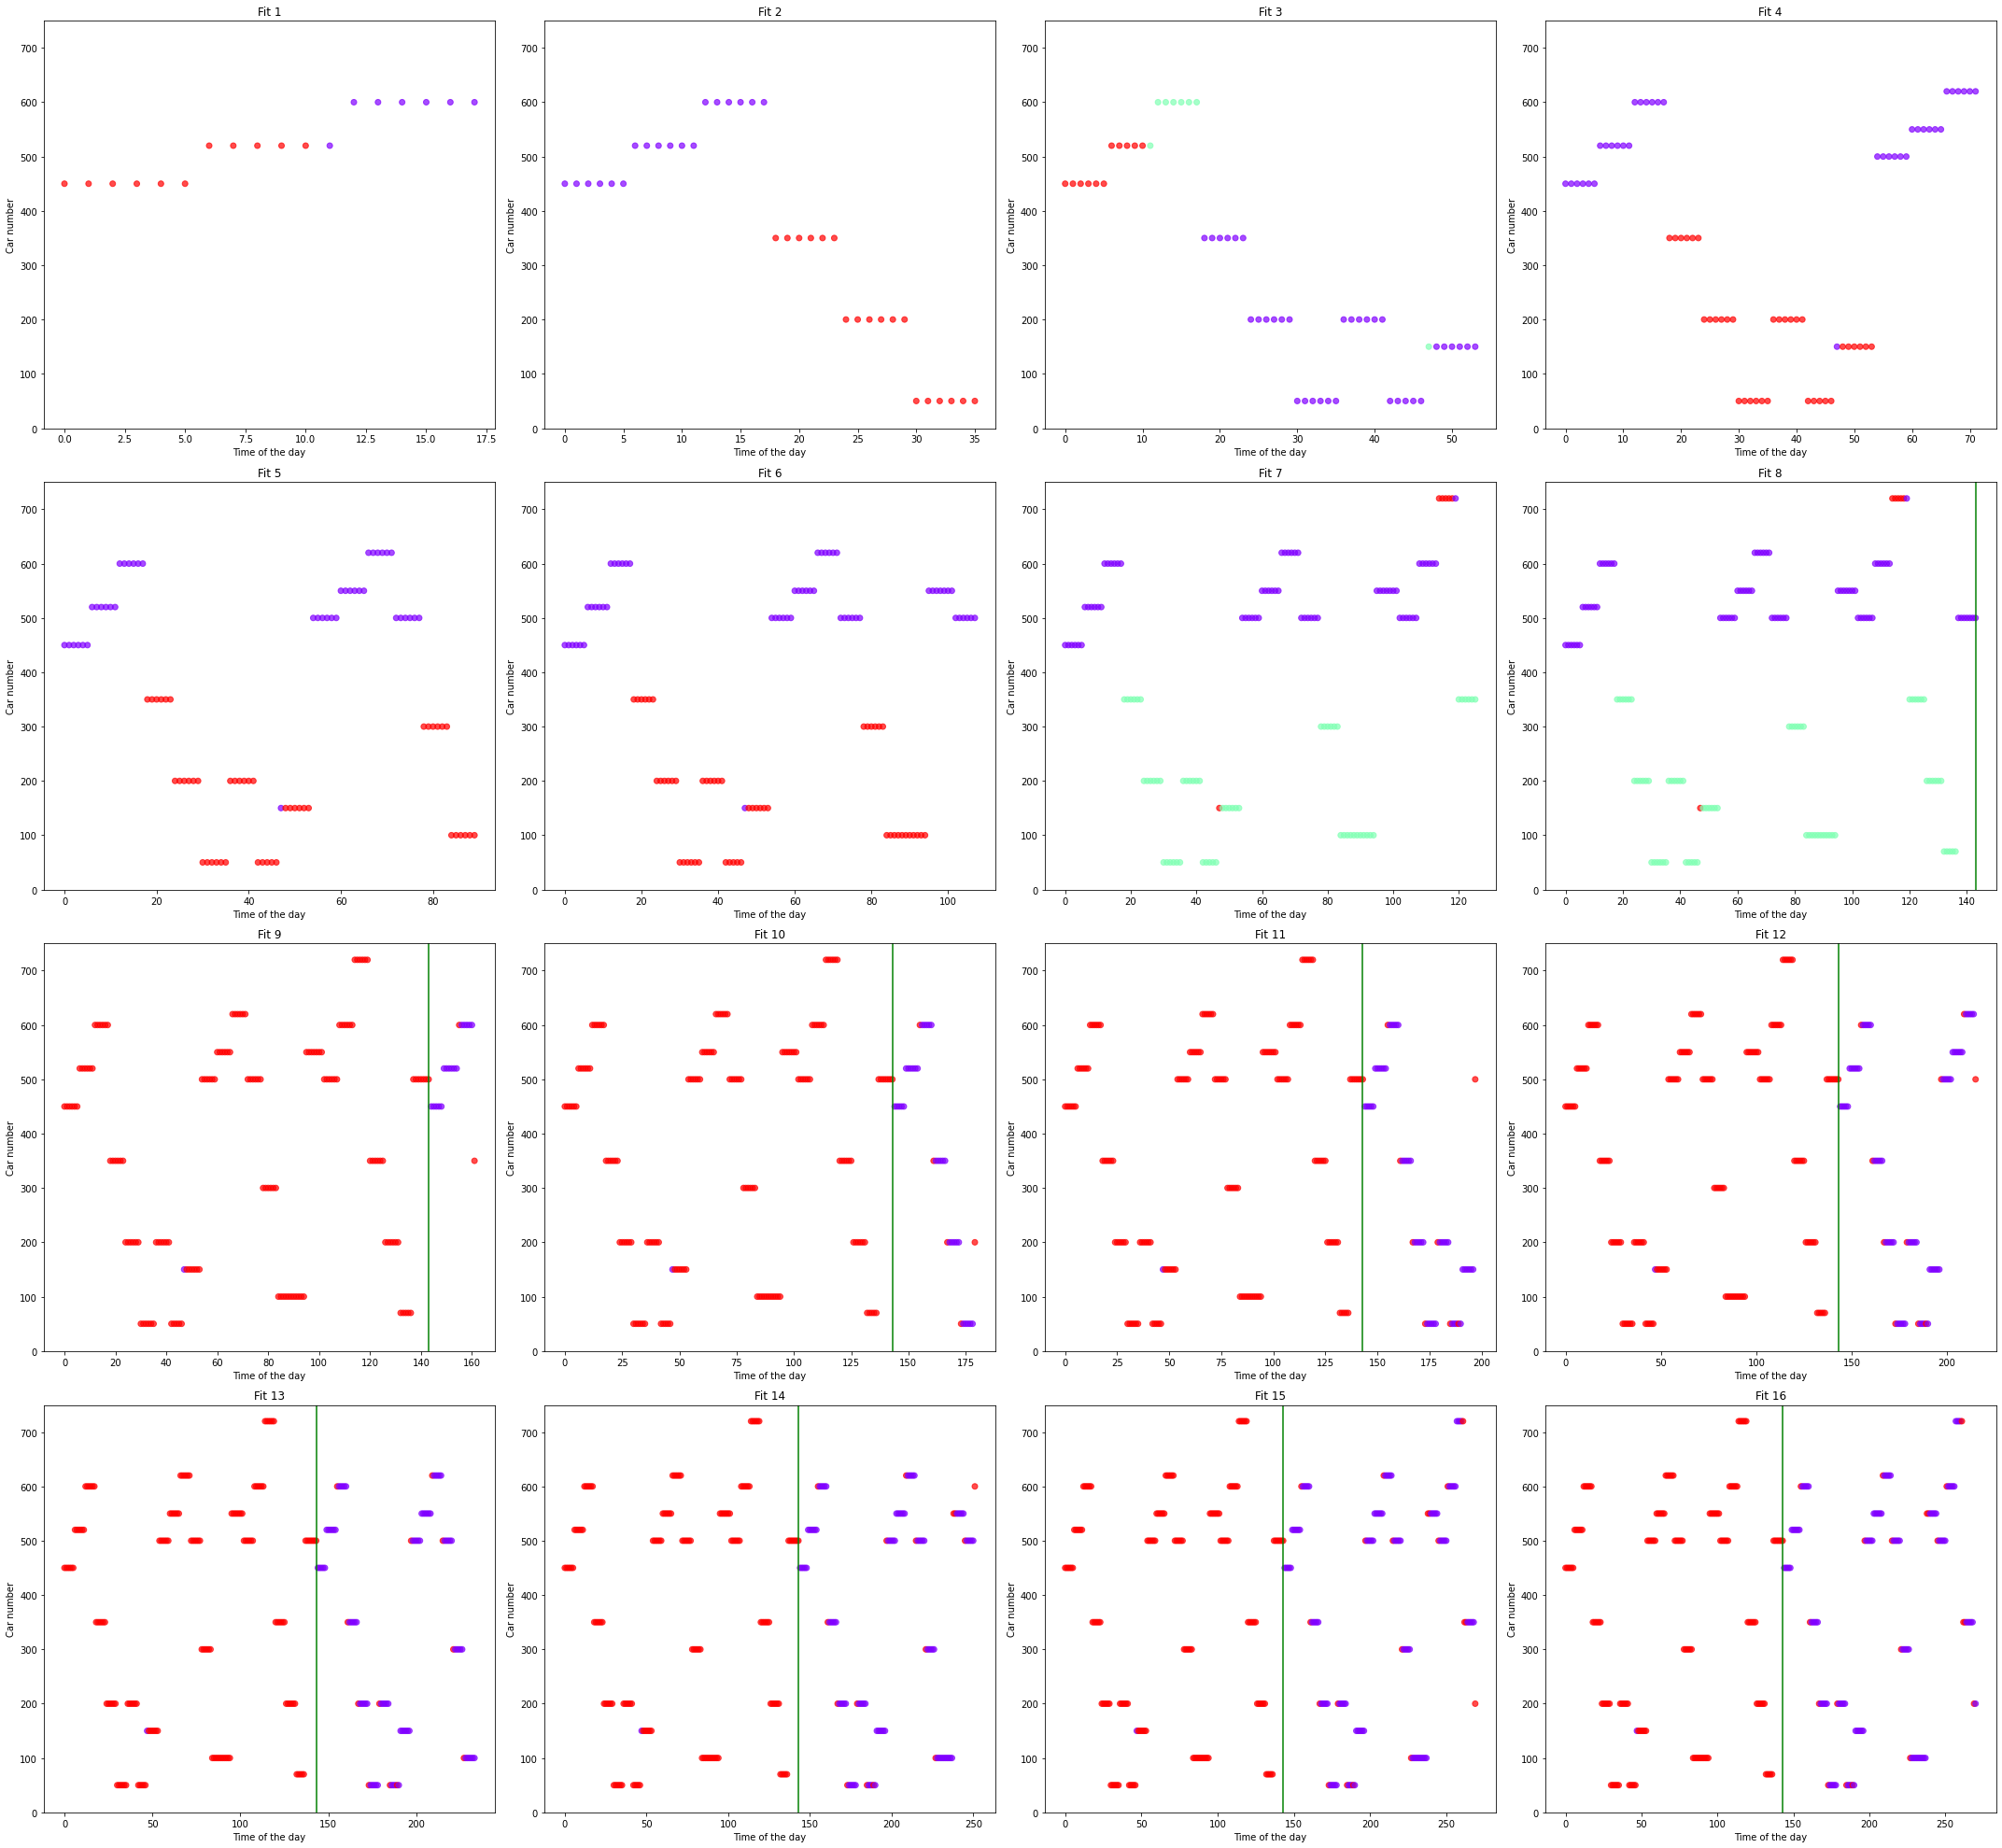

In [29]:
model_001_whole = Birch(n_clusters=None, threshold=0.2)
list_of_df_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

for i in list_of_dfs:
    add_data_to_this = pd.concat([add_data_to_this, i])
    
    numpy_array = outliers_removal(i)
    
    model_001_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_001_whole)
    
    new_nmpy = add_data_to_this.to_numpy()

    n = plot_silhouette_scores(model_copy, new_nmpy[:, 3:7], 2, 10, f'fit{fit_number}')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, 3:7])
    print(get_cal_score(new_nmpy[:, 3:7], labels_dict[f'fit_{fit_number}']))

    list_of_df_for_graphs.append(new_nmpy)
    fit_number += 1
    
    
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(30,30))

for i in list_of_df_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 0], i[:, 1], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number > 8:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

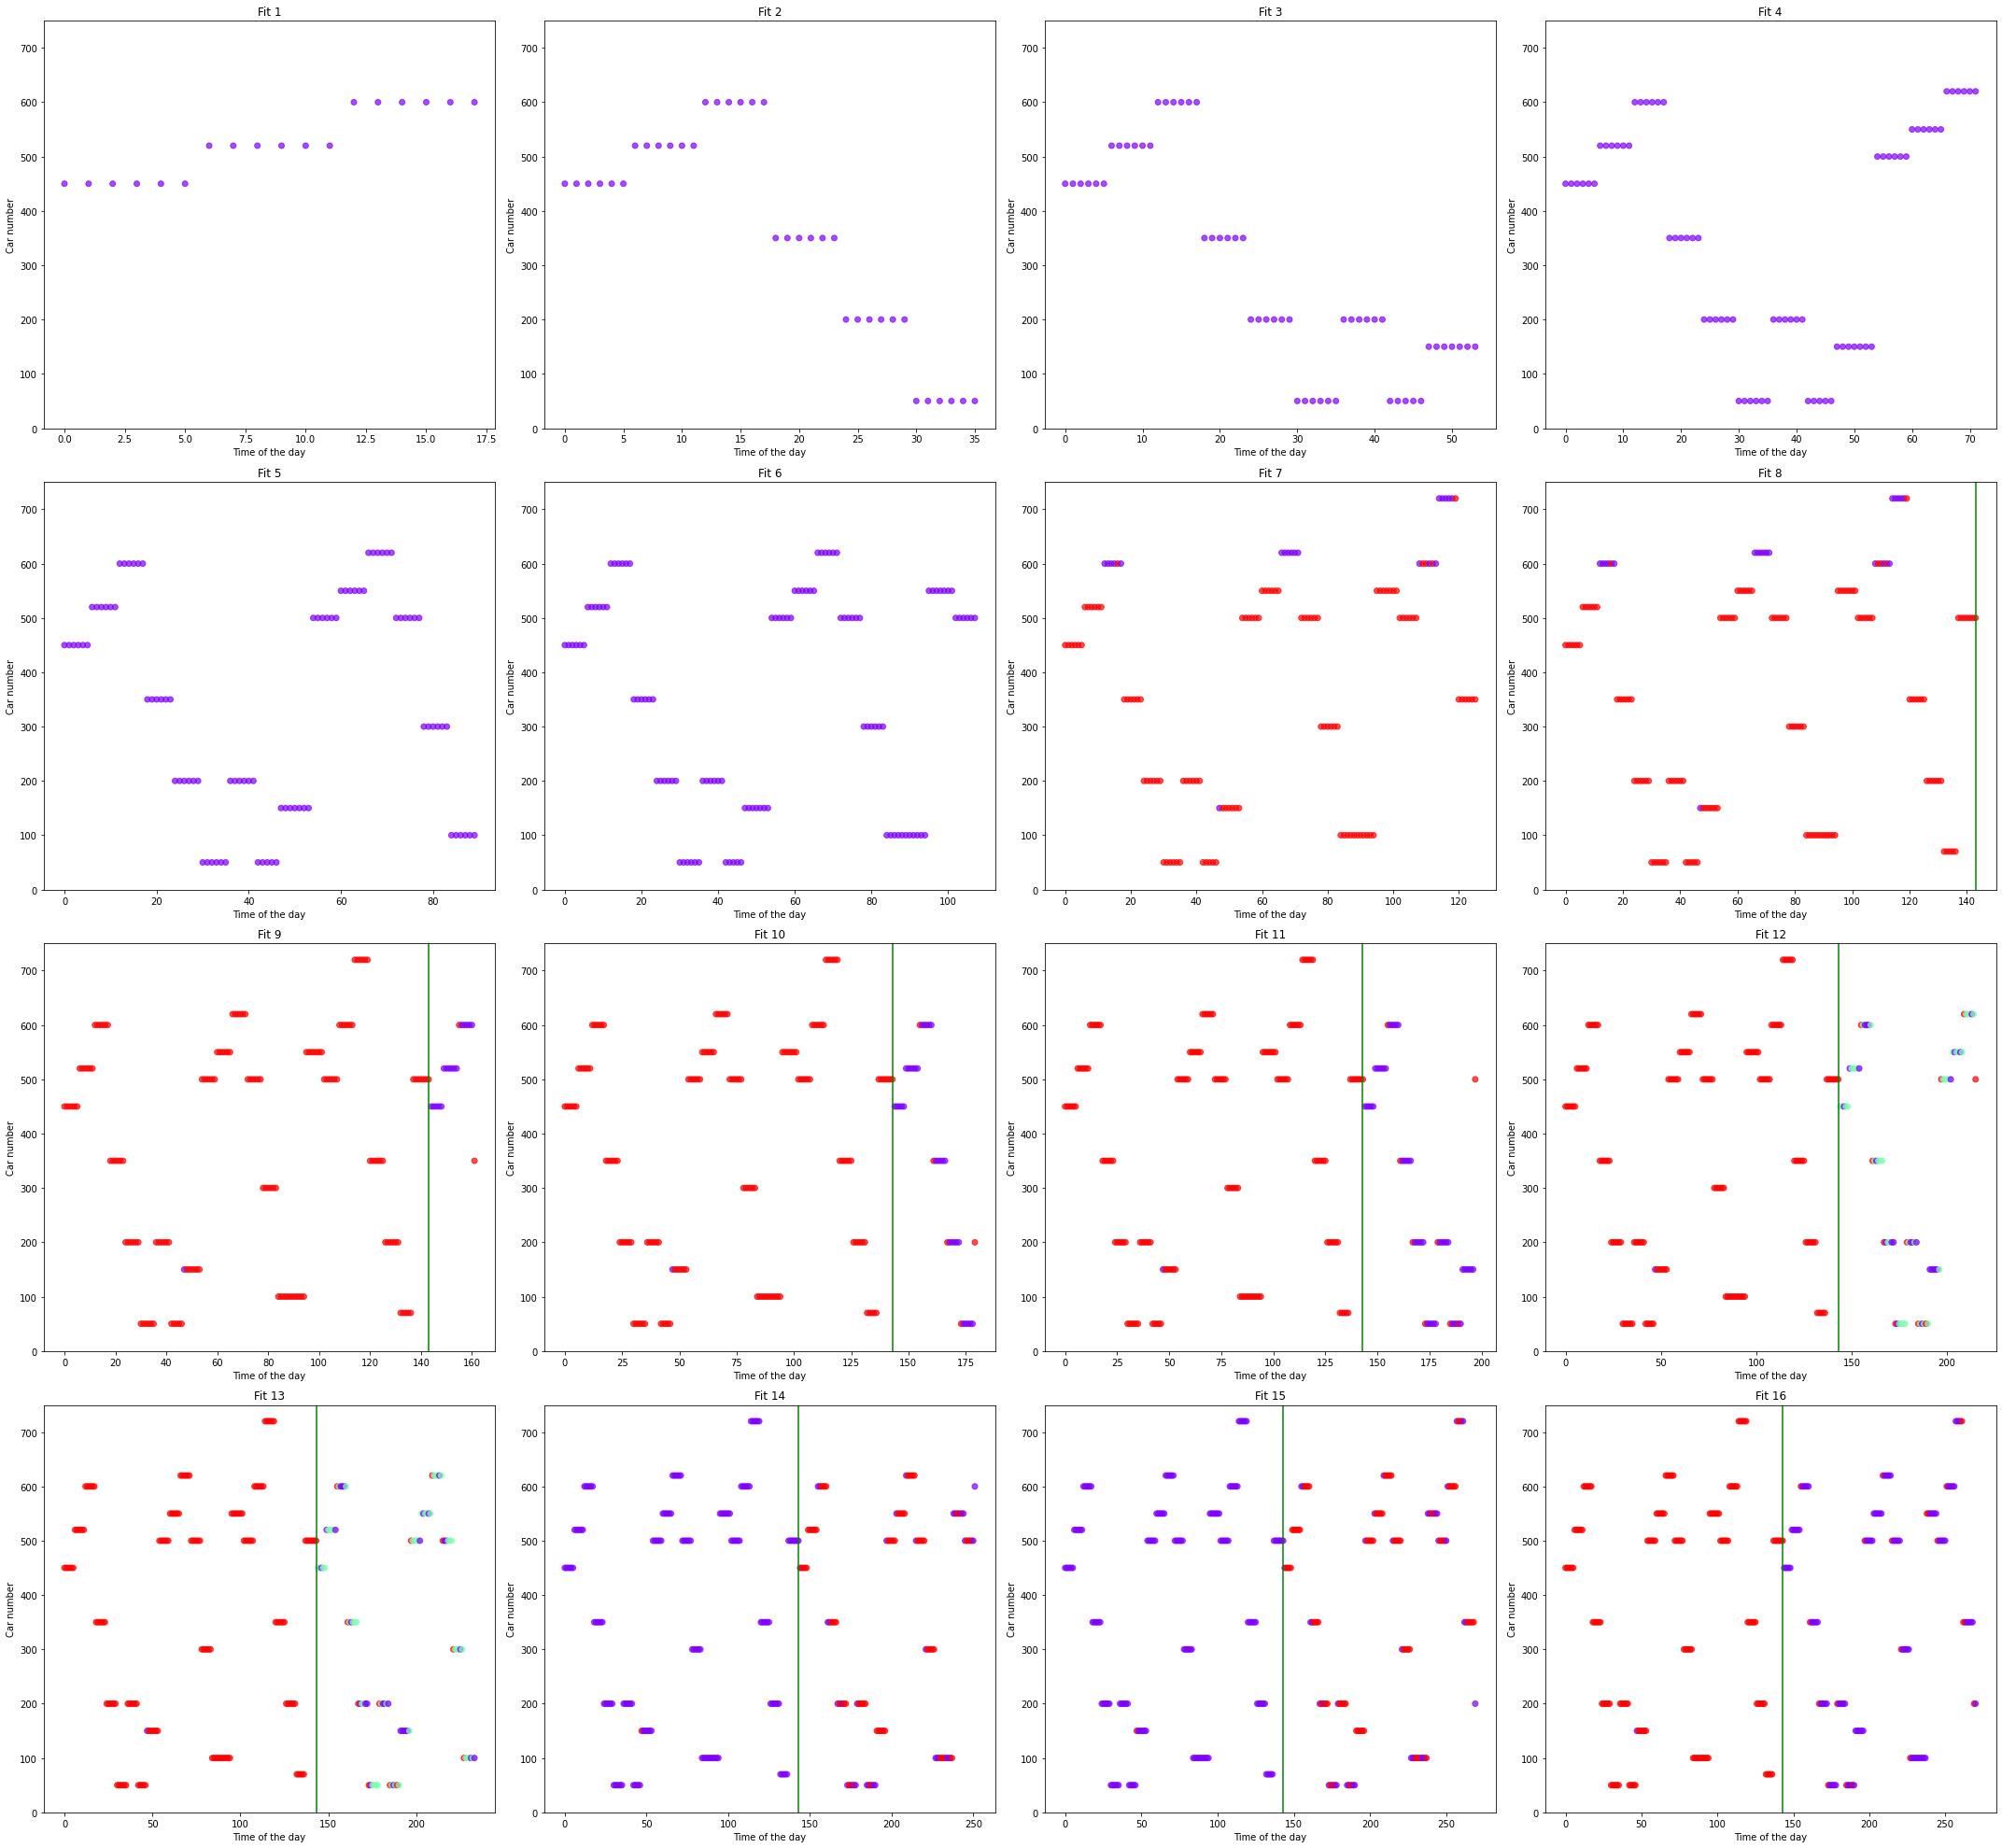

In [28]:
model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_df_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

for i in list_of_dfs:
    add_data_to_this = pd.concat([add_data_to_this, i])
    
    numpy_array = outliers_removal(i)
    
    model_05_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_05_whole)
    
    new_nmpy = add_data_to_this.to_numpy()

    n = plot_silhouette_scores(model_copy, new_nmpy[:, 3:7], 2, 10, f'fit{fit_number}')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, 3:7])
    
    list_of_df_for_graphs.append(new_nmpy)
    fit_number += 1
    
    
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(30,30))

for i in list_of_df_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 0], i[:, 1], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 8:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1